In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from tqdm import tqdm
from scipy import stats

dtype = torch.float32

device = "cuda"


In [2]:
L = 100
u = 0.01
alpha = 2.5
k1 = 1
k2 = 0.01
eps = 0.01

F0 = 1
m = 1
h = 0.1
width = 1000






def f(x,v,t,alpha,u):
    xIntoLeft = torch.roll(x,-1,dims=0)
    xIntoRight = torch.roll(x,1,dims=0)

    xIntoLeft[-1,:] = 0
    xIntoRight[0,:] = 0



    return torch.where(v==0,
    torch.where(torch.abs(-x*(2*k1 + k2) + (xIntoRight + xIntoLeft)*k1 + k2*u*t) < F0, -x*(2*k1 + k2) + (xIntoRight + xIntoLeft)*k1 + k2*u*t ,F0*(1-eps) ),
    F0*(1-eps)/(1+alpha*torch.abs(v)/(1-eps)))


def acc(x,v,t,alpha,u):
    xIntoLeft = torch.roll(x,-1,dims=0)
    xIntoRight = torch.roll(x,1,dims=0)

    xIntoLeft[-1,:] = 0
    xIntoRight[0,:] = 0

    return (-x*(2*k1 + k2) + (xIntoRight + xIntoLeft)*k1 + k2*u*t - f(x,v,t,alpha,u) )/m


def tenstion(x,v,t,alpha,u):
    return m*acc(x,v,t,alpha,u) + f(x,v,t,alpha,u)


def step(x,v,t,alpha,u):
    t = torch.where((v ==0).all( 0),t + (F0-tenstion(x,v,t,alpha,u).max(0)[0])/(k2*u) , t)


    k_1 = v
    l_1 = acc(x,v,t,alpha,u)

    k_2 = v + l_1*h/2
    l_2 = acc(x+k_1*h/2,v + l_1*h/2,t + h/2,alpha,u)

    k_3 = v + l_2*h/2
    l_3 = acc(x+k_2*h/2,v + l_2*h/2,t + h/2,alpha,u)

    k_4 = v + l_3/2
    l_4 = acc(x+k_3*h,v + l_3*h, t + h,alpha,u)

    deltax = (k_1 + 2*k_2 + 2*k_3 + k_4)*h/6

    # x = x +  deltax

    x = x + torch.where(deltax >  0, deltax , 0  )
    v = v +  (l_1 + 2*l_2 + 2*l_3 + l_4)*h/6

    v = torch.where(v<0, 0, v)
    return x, v,t+h

def run(x,v,t,steps,alpha,u,width,L):
    xdata = torch.zeros((steps,L,width),dtype=dtype,device = device)
    vdata = torch.zeros((steps,L,width),dtype=dtype,device = device)
    tdata = torch.zeros((steps,width),dtype=dtype,device = device)
    for i in range(steps):
        x,v,t = step(x,v,t,alpha,u)
        xdata[i] = x
        vdata[i] = v

    slipping = (vdata>0).any(dim=1)

    slippingR = slipping.roll(+1,dims = 0)
    slippingL = slipping.roll(-1,dims = 0)
    slippingR[0] = False
    slippingL[-1] = False

    ends  = torch.logical_xor( slipping ,(slipping *slippingL))
    starts  = torch.logical_xor( slipping ,(slipping *slippingR))

    totalX = xdata.sum(1)

    eventsSize = totalX.T[ends.T] - totalX.T[starts.T]

    eventsStep = (torch.argwhere(ends.T)  - torch.argwhere(starts.T))[:,1]

    eventsTime = tdata.T[ends.T] - tdata.T[starts.T]

    evetnsBlock = (xdata.permute(2,0,1)[ends.T] != xdata.permute(2,0,1)[starts.T]).sum(dim = 1)



    return x,v, t,eventsSize,eventsStep,eventsTime,evetnsBlock


def getData(iteration , steps ,alpha,u,width,L):
    means = torch.zeros(iteration)
    x = 0.1*(torch.rand((L,width),dtype=dtype,device=device) - 1)
    v = torch.zeros((L,width),dtype=dtype,device=device)
    t = torch.zeros(width,dtype=dtype,device=device)
    eventsSizes = torch.empty((0),dtype=dtype,device = device)
    eventsSteps = torch.empty((0),dtype=dtype,device = device)
    eventsTimes = torch.empty((0),dtype=dtype,device = device)
    evetnsBlocks = torch.empty((0),dtype=dtype,device = device)

    for i in tqdm(range(iteration)):
        x,v,t,eventsSize,eventsStep,eventsTime,evetnsBlock = run(x,v,t,steps,alpha,u,width,L)
        eventsSizes = torch.concatenate((eventsSizes,eventsSize))
        eventsSteps = torch.concatenate((eventsSteps,eventsStep))
        eventsTimes = torch.concatenate((eventsTimes,eventsTime))
        evetnsBlocks = torch.concatenate((evetnsBlocks,evetnsBlock))
        means[i] = eventsSize.mean()




    return  eventsSizes,eventsSteps,eventsTimes,means,evetnsBlocks

def getData2(iteration , steps ,alpha,u,width,L):
    means = torch.zeros(iteration)
    eventsSizes = torch.empty((0),dtype=dtype,device = device)
    eventsSteps = torch.empty((0),dtype=dtype,device = device)
    eventsTimes = torch.empty((0),dtype=dtype,device = device)
    evetnsBlocks = torch.empty((0),dtype=dtype,device = device)


    for i in tqdm(range(iteration)):
        x = 0.1*(torch.rand((L,width),dtype=dtype,device=device) - 1)
        v = torch.zeros((L,width),dtype=dtype,device=device)
        t = torch.zeros(width,dtype=dtype,device=device)
        x,v,t,eventsSize,eventsStep,eventsTime,evetnsBlock = run(x,v,t,steps,alpha,u,width,L)
        eventsSizes = torch.concatenate((eventsSizes,eventsSize))
        eventsSteps = torch.concatenate((eventsSteps,eventsStep))
        eventsTimes = torch.concatenate((eventsTimes,eventsTime))
        evetnsBlocks = torch.concatenate((evetnsBlocks,evetnsBlock))

        means[i] = eventsSize.mean()




    return  eventsSizes,eventsSteps,eventsTimes,means,evetnsBlocks


In [ ]:
for size in [100,200,300,400,500,600]:
    eventsSizes,eventsSteps,eventsTimes,means,evetnsBlocks1 = getData(200,1_000,alpha,u,1000,size)
    torch.save(eventsSizes, f"eventsSizes_{size}.pt")
    torch.save(eventsSteps, f"eventsSteps_{size}.pt")
    torch.save(eventsTimes, f"eventsTimes_{size}.pt")
    torch.save(means, f"means_{size}.pt")


In [3]:
eventsSizes,eventsSteps,eventsTimes,means,evetnsBlocks1 = getData2(200,1_000,alpha,u,1000,L)
print(eventsSizes.shape)
eventsSizes.cpu().min()

100%|██████████| 200/200 [10:10<00:00,  3.05s/it]

torch.Size([1431959])


tensor(0.)

In [3]:
eventsSizes_nonSS = torch.load("eventsSizes_nonSS.pt")

In [4]:
torch.save(eventsSizes.cpu(), "eventsSizes_nonSS.pt")

In [28]:
eventsSizes2,eventsSteps2,eventsTimes2,means2,evetnsBlocks = getData(100,20_000,alpha,u,10)
print(eventsSizes2.shape)
eventsSizes2.cpu().min()

100%|██████████| 100/100 [1:24:29<00:00, 50.70s/it]

torch.Size([3196])


tensor(0.)

In [29]:
torch.save(eventsSizes2, "eventsSizes2.pt")
torch.save(eventsSteps2, "eventsSteps2.pt")
torch.save(eventsTimes2, "eventsTimes2.pt")
torch.save(means2, "means2.pt")

torch.save(eventsSizes, "eventsSizes.pt")
torch.save(eventsSteps, "eventsSteps.pt")
torch.save(eventsTimes, "eventsTimes.pt")
torch.save(means, "means.pt")

In [18]:
(eventsSizes+1).min()

tensor(1., device='cuda:0')

slope is -0.03342538920280071


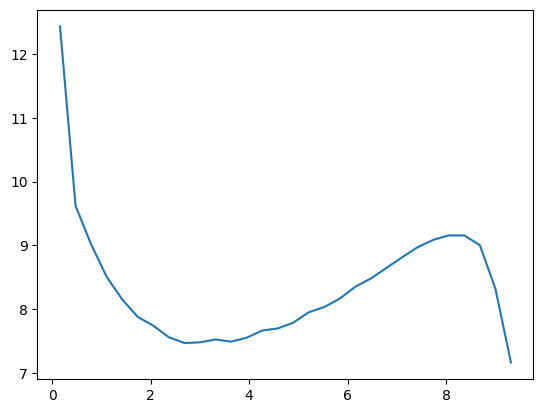

In [5]:
freq , size = np.histogram(np.log((eventsSizes2+1).cpu()), bins = 30)
size = (size[1:] + size[:-1])/2

plt.plot(size, np.log(freq))

print(f"slope is {stats.linregress(size[freq>0], np.log(freq[freq>0]))[0]}")

In [6]:
freq , size = np.histogram(np.log((eventsSizes+1).cpu()), bins = 30)
size = (size[1:] + size[:-1])/2

plt.plot(size, np.log(freq))

print(f"slope is {stats.linregress(size[freq>0], np.log(freq[freq>0]))[0]}")

NameError: name 'eventsSizes' is not defined

slope is 0.048289775001976315


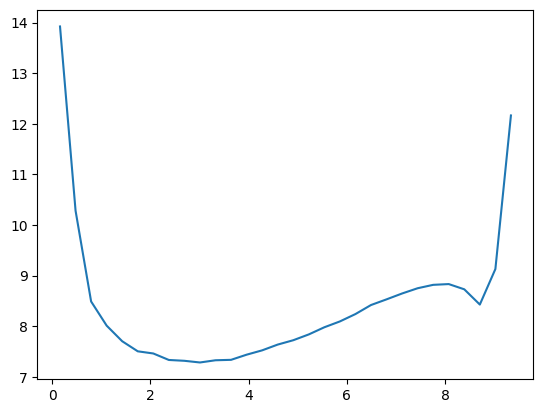

In [7]:
freq , size = np.histogram(np.log((eventsSizes_nonSS+1).cpu()), bins = 30)
size = (size[1:] + size[:-1])/2

plt.plot(size, np.log(freq))

print(f"slope is {stats.linregress(size[freq>0], np.log(freq[freq>0]))[0]}")

RuntimeError: The size of tensor a (385255) must match the size of tensor b (1431959) at non-singleton dimension 0

slope is -0.797256720640339 and r_value = -0.9853608077045245


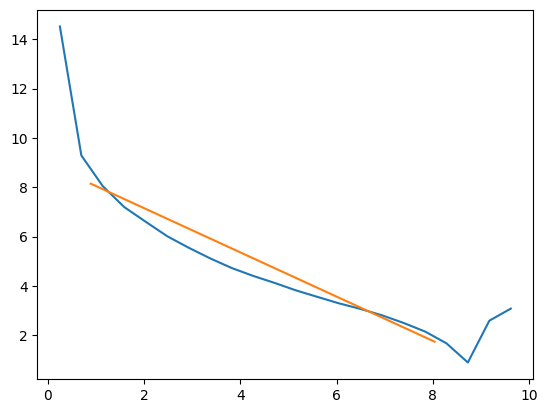

In [10]:

eventsSizes = eventsSizes_nonSS + 1
bins = np.logspace(np.log((eventsSizes.cpu())[eventsSizes.cpu()   > 0].min()),np.log((eventsSizes.cpu()+1)[eventsSizes.cpu()   > 0].max()),50)

freq , size = np.histogram((eventsSizes.cpu())[eventsSizes.cpu()  > 0], bins = bins)


bins_size = (size - np.roll(size,1))[1:]
freq = freq / bins_size




size = (size[1:] + size[:-1])/2

plt.plot(np.log(size[freq>0]), np.log(freq[freq>0]))





index1 , index2 = 2 , -3

slope , intercept , rvalue , _, _  = stats.linregress(np.log(size[freq>0][index1:index2]), np.log(freq[freq>0][index1:index2]))

plt.plot([np.log(freq[freq>0])[index2], np.log(freq[freq>0])[index1]] , [intercept , intercept + slope*np.log(freq[freq>0])[index1]] )
print(f"slope is {slope} and r_value = {rvalue}")


slope is -1.1041794818852257 and r_value = -0.9415441228994559


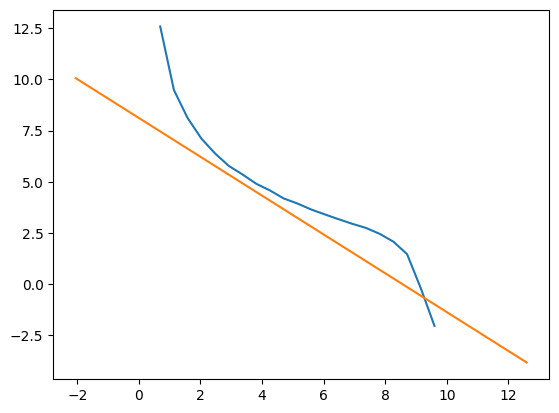

In [9]:
eventsSizes = eventsSizes100 +1 
bins = np.logspace(np.log(eventsSizes.cpu()[eventsSizes.cpu()   > 0].min()),np.log((eventsSizes.cpu().max())),50)

freq , size = np.histogram((eventsSizes.cpu()+1)[eventsSizes.cpu()  > 0], bins = bins)


bins_size = (size - np.roll(size,1))[1:]
freq = freq / bins_size




size = (size[1:] + size[:-1])/2

plt.plot(np.log(size[freq>0]), np.log(freq[freq>0]))

slope , intercept , rvalue , _, _  = stats.linregress(np.log(size[freq>0]), np.log(freq[freq>0]))

print(f"slope is {slope} and r_value = {rvalue}")

plt.plot([np.log(freq[freq>0])[-1], np.log(freq[freq>0])[0]] , [intercept , intercept + slope*np.log(freq[freq>0])[0]] )


In [54]:
np.log(freq[freq>0])[-1]

-0.9528146372253399

In [ ]:

bins_size = (size - np.roll(size,1))[1:]
freq = freq / bins_size




size = (size[1:] + size[:-1])/2

plt.plot(np.log(size[freq>0]), np.log(freq[freq>0]))


print(f"slope is {stats.linregress(np.log(size[freq>0]), np.log(freq[freq>0]))[0]}")

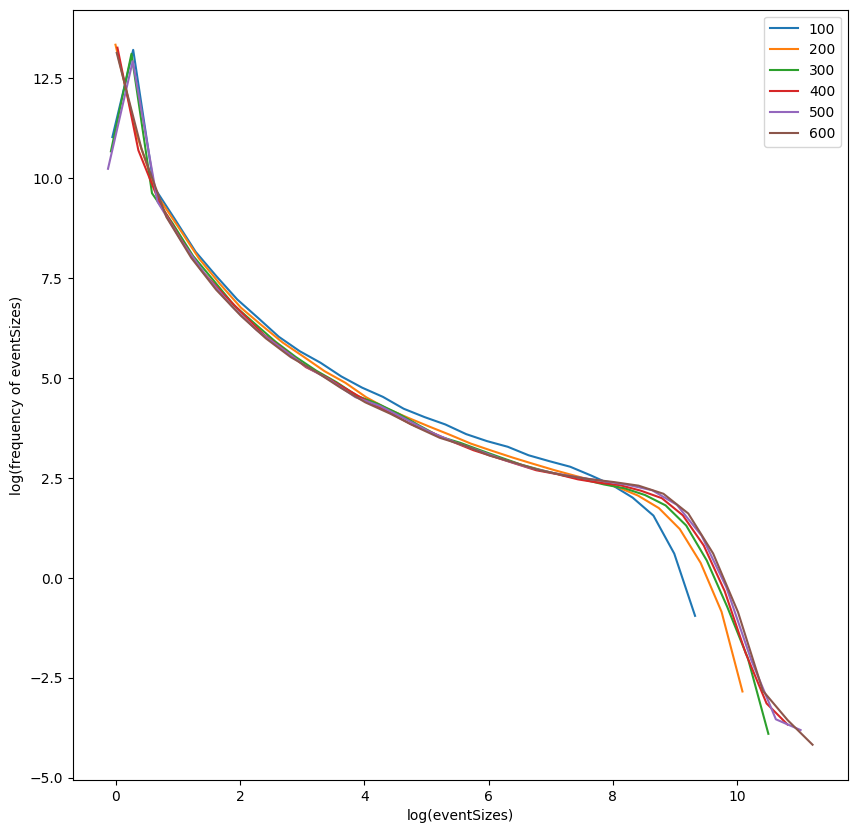

In [4]:
eventsSizes100 = torch.load("eventsSizes_100.pt")
eventsSizes200 = torch.load("eventsSizes_200.pt")
eventsSizes300 = torch.load("eventsSizes_300.pt")
eventsSizes400 = torch.load("eventsSizes_400.pt")
eventsSizes500 = torch.load("eventsSizes_500.pt")
eventsSizes600 = torch.load("eventsSizes_600.pt")
eventsSizes2 = torch.load("eventsSizes_100.pt")

# plt.title("log(frequency of eventSizes) vs log(eventSizes) for independent sampling")

nbins = 50

bins1 = np.logspace(np.log10(eventsSizes100.cpu()[eventsSizes100.cpu()   > 0].min()),np.log10((eventsSizes100.cpu().max())),nbins)
bins2 = np.logspace(np.log10(eventsSizes200.cpu()[eventsSizes200.cpu()   > 0].min()),np.log10((eventsSizes200.cpu().max())),nbins)
bins3 = np.logspace(np.log10(eventsSizes300.cpu()[eventsSizes300.cpu()   > 0].min()),np.log10((eventsSizes300.cpu().max())),nbins)
bins4 = np.logspace(np.log10(eventsSizes400.cpu()[eventsSizes400.cpu()   > 0].min()),np.log10((eventsSizes400.cpu().max())),nbins)
bins5 = np.logspace(np.log10(eventsSizes500.cpu()[eventsSizes500.cpu()   > 0].min()),np.log10((eventsSizes500.cpu().max())),nbins)
bins6 = np.logspace(np.log10(eventsSizes600.cpu()[eventsSizes600.cpu()   > 0].min()),np.log10((eventsSizes600.cpu().max())),nbins)


freq1,size1 = np.histogram((eventsSizes100+1).cpu(),bins=bins1)
freq2,size2 = np.histogram((eventsSizes200+1).cpu(),bins=bins2)
freq3,size3 = np.histogram((eventsSizes300+1).cpu(),bins=bins3)
freq4,size4 = np.histogram((eventsSizes400+1).cpu(),bins=bins4)
freq5,size5 = np.histogram((eventsSizes500+1).cpu(),bins=bins5)
freq6,size6 = np.histogram((eventsSizes600+1).cpu(),bins=bins6)



bins_size1 = (size1 - np.roll(size1,1))[1:]
bins_size2 = (size2 - np.roll(size2,1))[1:]
bins_size3 = (size3 - np.roll(size3,1))[1:]
bins_size4 = (size4 - np.roll(size4,1))[1:]
bins_size5 = (size5 - np.roll(size5,1))[1:]
bins_size6 = (size6 - np.roll(size6,1))[1:]


freq1 = freq1 / bins_size1
freq2 = freq2 / bins_size2
freq3 = freq3 / bins_size3
freq4 = freq4 / bins_size4
freq5 = freq5 / bins_size5
freq6 = freq6 / bins_size6


size1 = (size1[1:] + size1[:-1])/2
size2 = (size2[1:] + size2[:-1])/2
size3 = (size3[1:] + size3[:-1])/2
size4 = (size4[1:] + size4[:-1])/2
size5 = (size5[1:] + size5[:-1])/2
size6 = (size6[1:] + size6[:-1])/2






# plt.plot(size1[:-1],freq1)
# plt.plot(size2[:-1],freq2)
# plt.plot(size3[:-1],freq3)
# plt.plot(size4[:-1],freq4)
# plt.plot(size5[:-1],freq5)
# plt.plot(size6[:-1],freq6)

# plt.xlim((np.exp(9),np.exp(9.5)))
# plt.ylim((0,1000))


plt.figure(figsize=(10,10))

exponent = 0
plt.plot(np.log(size1[freq1>0]),np.log(freq1[freq1>0])*100**exponent)
plt.plot(np.log(size2[freq2>0]),np.log(freq2[freq2>0])*200**exponent)
plt.plot(np.log(size3[freq3>0]),np.log(freq3[freq3>0])*300**exponent)
plt.plot(np.log(size4[freq4>0]),np.log(freq4[freq4>0])*400**exponent)
plt.plot(np.log(size5[freq5>0]),np.log(freq5[freq5>0])*500**exponent)
plt.plot(np.log(size6[freq6>0]),np.log(freq6[freq6>0])*600**exponent)



plt.xlabel("log(eventSizes)")
plt.ylabel("log(frequency of eventSizes)")
plt.legend([100,200,300,400,500,600])

# plt.savefig("fig1_1.png")

/tmp/ipykernel_10050/3095781431.py:5: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(size[:-1]),np.log(freq))
/tmp/ipykernel_10050/3095781431.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("fig1_1.png")
/tmp/ipykernel_10050/3095781431.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("fig1_1.png")
/tmp/ipykernel_10050/3095781431.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("fig1_1.png")
/tmp/ipykernel_10050/3095781431.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inches_restore" which is no longer

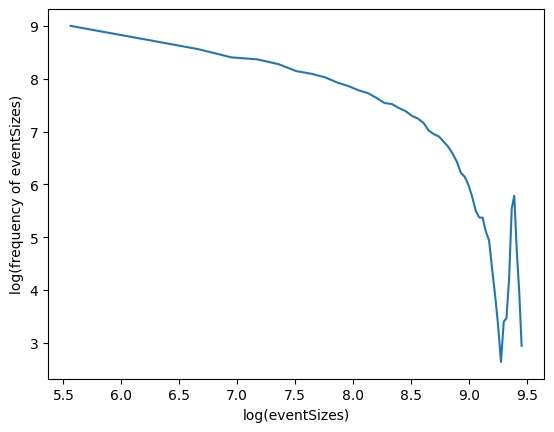

In [51]:
freq,size = np.histogram((eventsSizes100).cpu(),bins=50)
# plt.title("log(frequency of eventSizes) vs log(eventSizes) for independent sampling")
plt.xlabel("log(eventSizes)")
plt.ylabel("log(frequency of eventSizes)")
plt.plot(np.log(size[:-1]),np.log(freq))
plt.savefig("fig1_1.png")

/tmp/ipykernel_10050/1678289797.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("fig1_1.png")
/tmp/ipykernel_10050/1678289797.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("fig1_1.png")
/tmp/ipykernel_10050/1678289797.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("fig1_1.png")
/tmp/ipykernel_10050/1678289797.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inches_restore" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("fig1_1.png")


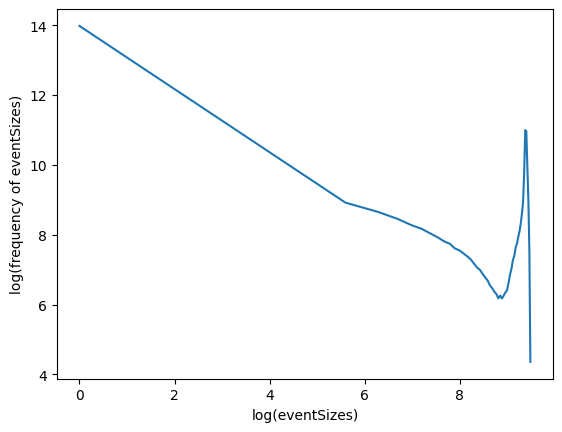

In [52]:
freq,size = np.histogram((eventsSizes).cpu(),bins=50)
# plt.title("log(frequency of eventSizes) vs log(eventSizes) for independent sampling")
plt.xlabel("log(eventSizes)")
plt.ylabel("log(frequency of eventSizes)")
plt.plot(np.log(size[:-1]),np.log(freq))
plt.savefig("fig1_1.png")


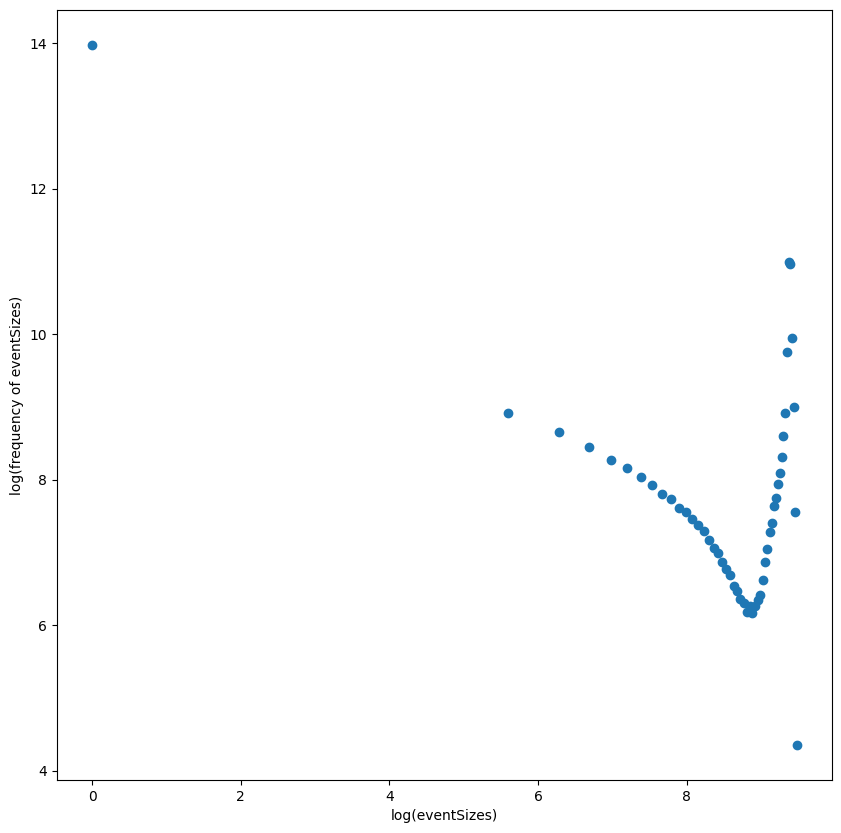

In [53]:
plt.figure(figsize = (10,10))
freq,size = np.histogram(eventsSizes.cpu(),bins=50)
# plt.title("log(frequency of eventSizes) vs log(eventSizes) for dependent sampling")
plt.xlabel("log(eventSizes)")
plt.ylabel("log(frequency of eventSizes)")
plt.scatter(np.log(size[:-1]),np.log(freq))
# plt.savefig("fig1_2.png")

# Investigating the steady state

/tmp/ipykernel_4262/2558366735.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("fig2_1.png")
/tmp/ipykernel_4262/2558366735.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("fig2_1.png")
/tmp/ipykernel_4262/2558366735.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("fig2_1.png")
/tmp/ipykernel_4262/2558366735.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inches_restore" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("fig2_1.png")


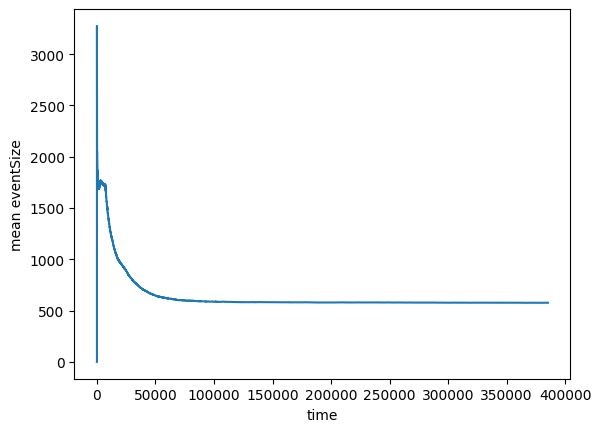

In [9]:
ev = eventsSizes.cpu()
# plt.title("mean eventSize vs time for independent sampling")
plt.xlabel("time")
plt.ylabel("mean eventSize")
plt.plot(np.arange(ev.shape[0]) , (ev.cumsum(dim=0) / torch.arange(1, ev.shape[0] + 1 )).cpu())
plt.savefig("fig2_1.png")

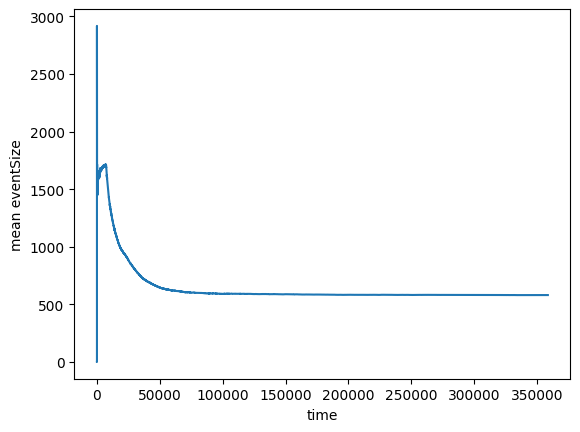

In [ ]:
ev = eventsSizes2.cpu()
# plt.title("mean eventSize vs time for dependent sampling")
plt.xlabel("time")
plt.ylabel("mean eventSize")
plt.plot(np.arange(ev.shape[0]) , (ev.cumsum(dim=0) / torch.arange(1, ev.shape[0] + 1 )).cpu())
plt.savefig("fig2_2.png")

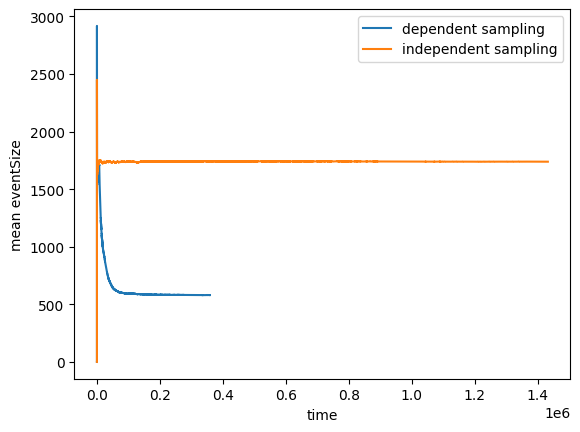

In [ ]:
# plt.title("mean eventSize vs time")
plt.xlabel("time")
plt.ylabel("mean eventSize")
ev = eventsSizes2.cpu()
plt.plot(np.arange(ev.shape[0]) , (ev.cumsum(dim=0) / torch.arange(1, ev.shape[0] + 1 )).cpu())
ev = eventsSizes.cpu()
plt.plot(np.arange(ev.shape[0]) , (ev.cumsum(dim=0) / torch.arange(1, ev.shape[0] + 1 )).cpu())
plt.legend(["dependent sampling","independent sampling"])
plt.savefig("fig2_3.png")
# ev = eventsSizes3.cpu()
# plt.plot(np.arange(ev.shape[0]) , (ev.cumsum(dim=0) / torch.arange(1, ev.shape[0] + 1 )).cpu())

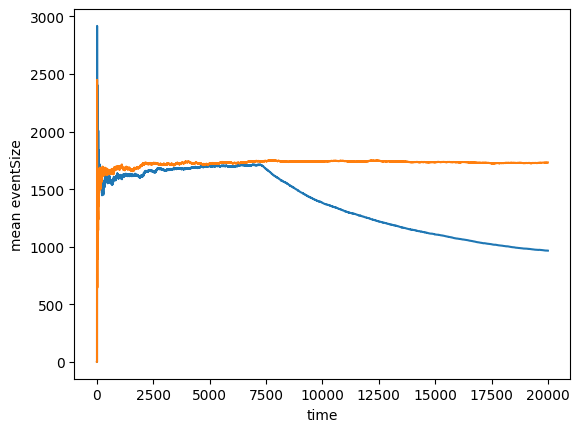

In [ ]:
# plt.title("mean eventSize vs time ( zoomed)")
plt.xlabel("time")
plt.ylabel("mean eventSize")
index = 20000
ev = eventsSizes2.cpu()[:index]
plt.plot(np.arange(ev.shape[0]) , (ev.cumsum(dim=0) / torch.arange(1, ev.shape[0] + 1 )).cpu())
ev = eventsSizes.cpu()[:index]
plt.plot(np.arange(ev.shape[0]) , (ev.cumsum(dim=0) / torch.arange(1, ev.shape[0] + 1 )).cpu())
plt.savefig("fig2_4.png")
# ev = eventsSizes3.cpu()[:index]
# plt.plot(np.arange(ev.shape[0]) , (ev.cumsum(dim=0) / torch.arange(1, ev.shape[0] + 1 )).cpu())

In [ ]:
# freq,size = np.histogram(eventsSizes.cpu(),bins=np.logspace(np.log10(eventsSizes.cpu()[eventsSizes.cpu().nonzero()].min()),np.log10((eventsSizes.cpu().max())),50))
# plt.scatter(np.log(size[:-1]),np.log(freq))

# EventsSizes vs EventsSteps

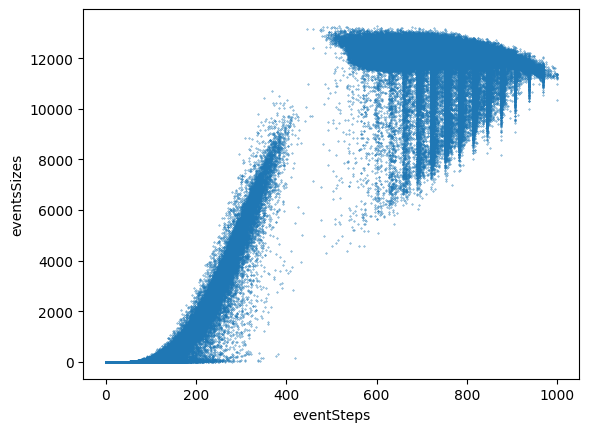

In [ ]:
# plt.title(" eventsSizes vs eventSteps for independent sampling")
plt.xlabel("eventSteps")
plt.ylabel("eventsSizes")
plt.scatter(eventsSteps.cpu(),eventsSizes.cpu(),s= 0.1)
plt.savefig("fig3_1.png")

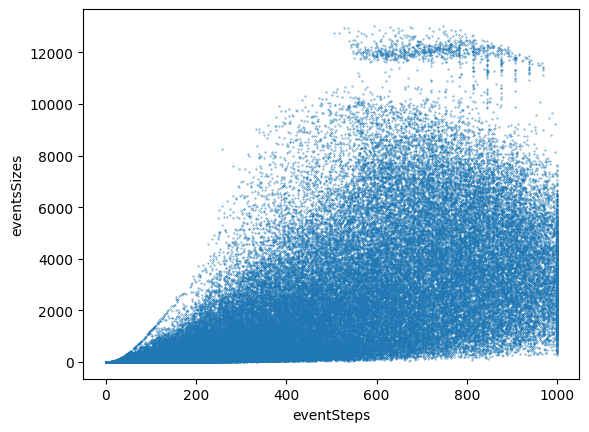

In [ ]:
# plt.title(" eventsSizes vs eventSteps for dependent sampling")
plt.xlabel("eventSteps")
plt.ylabel("eventsSizes")
plt.scatter(eventsSteps2.cpu(),eventsSizes2.cpu(),s= 0.1)
plt.savefig("fig3_2.png")

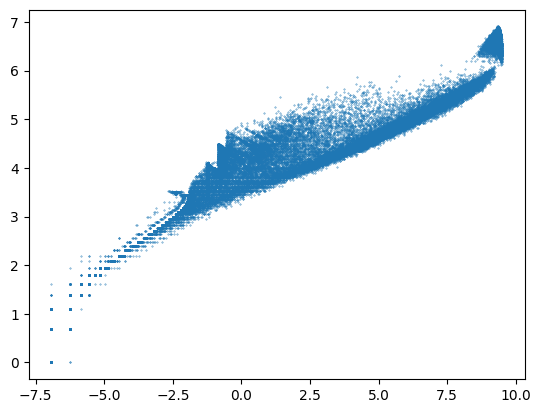

In [ ]:
plt.scatter(torch.log(eventsSizes.cpu()),torch.log(eventsSteps.cpu() ), s= 0.1)

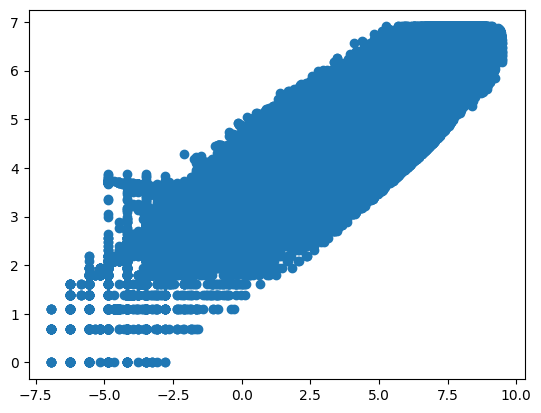

In [ ]:
plt.scatter(torch.log(eventsSizes2.cpu()),torch.log(eventsSteps2.cpu() ))

# EventsBlocks vs EventsSizes

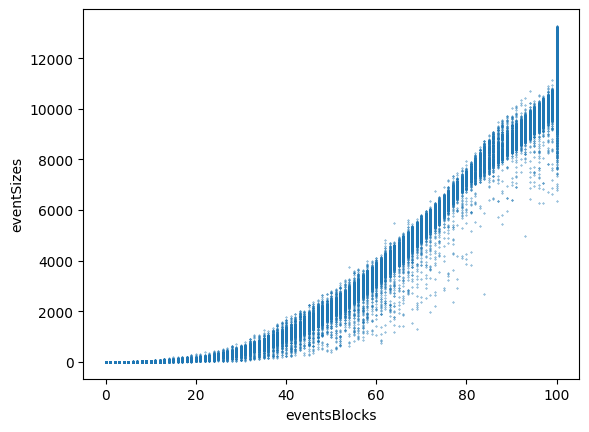

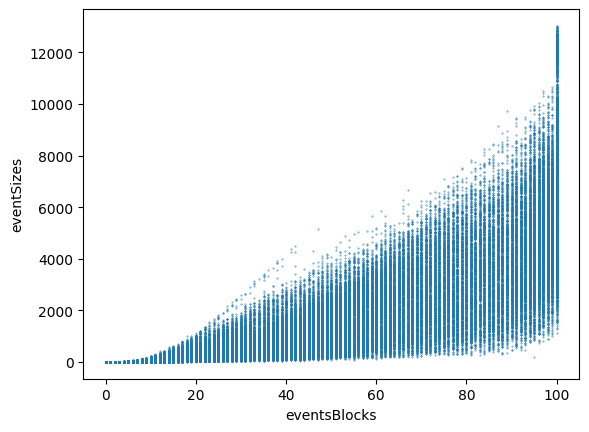

In [ ]:
# plt.title(" eventsSteps vs eventBlocks for independent sampling")
plt.xlabel("eventsBlocks")
plt.ylabel("eventSizes")


plt.scatter(evetnsBlocks1.cpu(),eventsSizes.cpu(), s= 0.1)
plt.savefig("fig4_1.png")
plt.show()


# plt.title(" eventsSteps vs eventBlocks for dependent sampling")
plt.xlabel("eventsBlocks")
plt.ylabel("eventSizes")
plt.scatter(evetnsBlocks.cpu(),eventsSizes2.cpu(), s= 0.1)
plt.savefig("fig4_2.png")


# Cutting the tail 

<ipython-input-18-29f821a695e9>:6: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(size[:-1]),np.log(freq))


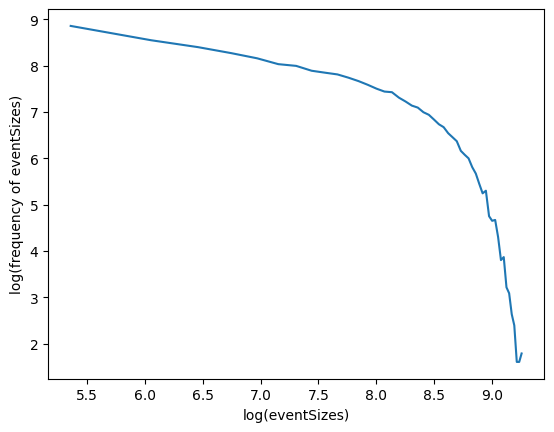

<ipython-input-18-29f821a695e9>:16: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(size[:-1]),np.log(freq))


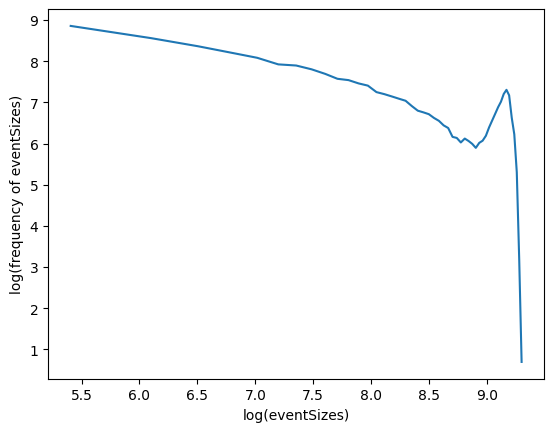

In [ ]:
# plt.title("log(frequency of eventSizes) vs log(eventSizes) for dependent sampling")
plt.xlabel("log(eventSizes)")
plt.ylabel("log(frequency of eventSizes)")
filtered = eventsSizes2[torch.argwhere(evetnsBlocks != 100)].cpu()
freq,size = np.histogram(filtered,bins=50)
plt.plot(np.log(size[:-1]),np.log(freq))
plt.savefig("fig5_1.png")
plt.show()


# plt.title("log(frequency of eventSizes) vs log(eventSizes) for independent sampling")
plt.xlabel("log(eventSizes)")
plt.ylabel("log(frequency of eventSizes)")
filtered = eventsSizes[torch.argwhere(evetnsBlocks1 != 100)].cpu()
freq,size = np.histogram(filtered,bins=50)
plt.plot(np.log(size[:-1]),np.log(freq))
plt.savefig("fig5_2.png")


In [47]:
# files.download("fig4_1.png")
# files.download("fig4_2.png")